In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# XGBoost 
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz, plot_tree
print("XGBoost version:",xgboost.__version__)

from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mycmap = "winter"
mpl.rcParams['image.cmap'] = mycmap
plt.rcParams['font.size'] = 13

XGBoost version: 3.0.0


In [4]:
np.random.seed(12345)

dname="./DATA/"
str0="_XGB_25.dat"
fnamex=dname+'x'+str0
fnamey=dname+'y'+str0
x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
y = np.loadtxt(fnamey)
y = y.astype(int)
N,L = len(x), len(x[0])

N_train = int(0.75*N)
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
print(f"N={N}, N_train={N_train}, L={L}")


N=5000, N_train=3750, L=4


[-31.608 -29.544   6.773   9.554] 0
[46.451 15.318 24.891 15.357] 0
[ 24.771  46.131 -49.161 -39.356] 0
[-20.13   15.641  30.981  37.218] 0
[46.465 22.369 14.248 21.745] 0


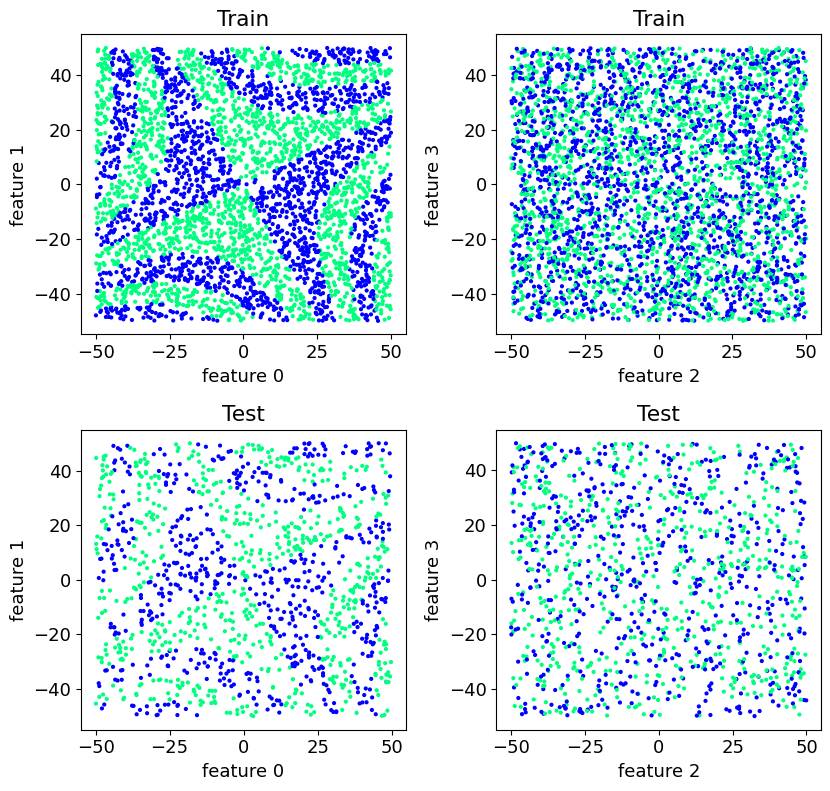

In [5]:
def scat(ax,x,y,i=0,j=1,s=4,title=""):
    ax.scatter(x[:,i],x[:,j],s=s,c=y)
    ax.set_xlabel(f"feature {i}")
    ax.set_ylabel(f"feature {j}")
    ax.set_title(title)

for n in range(5):
    print(x[n],y[n])

fig,AX = plt.subplots(2,2,figsize=(8.5,8.1))
scat(AX[0,0],x_train,y_train,title="Train")
scat(AX[0,1],x_train,y_train,i=2,j=3,title="Train")
scat(AX[1,0],x_test,y_test,title="Test")
scat(AX[1,1],x_test,y_test,i=2,j=3,title="Test")
fig.tight_layout()
plt.show()

In [6]:
def classify(clf=GradientBoostingClassifier(),show=False):
    # GradientBoostingClassifier():
    #   n_estimators = 100 (default)
    #   loss function = deviance(default) used in Logistic Regression
    # XGBClassifier()
    #   n_estimators = 100 (default)
    #   max_depth = 3 (default?)
    clf.fit(x_train,y_train)
    y_hat = clf.predict(x_test)
    
    print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-clf.score(x_test, y_test)),clf.score(x_test, y_test)))
    S=50
    dx = 1
    x_seq=np.arange(-S,S+dx,dx)
    nx = len(x_seq)
    x_plot=np.zeros((nx*nx,x_train.shape[1]))
    q=0
    for i in range(nx):
        for j in range(nx):
            x_plot[q,:2] = [x_seq[i],x_seq[j]]
            q+=1
    y_plot= clf.predict(x_plot)

    fig,AX = plt.subplots(1,2,figsize=(8.2,4))
    scat(AX[0],x_plot[:],y_plot,s=dx,title="predicted")
    scat(AX[1],x_train[:],y_train,title="training set")
    fig.tight_layout()
    plt.show()
    
    if show:      
        dump_list = clf.get_booster().get_dump()
        num_trees = len(dump_list)
        print("num_trees=",num_trees)
        
        fig, AX = plt.subplots(2,1,figsize=(12, 5))
        for i in range(min(2,num_trees)):
            ax=AX[i]
            plot_tree(clf, num_trees=i, ax=ax)
        fig.savefig("DATA/tree-classif.png", dpi=400, pad_inches=0.02)   
        plt.show()

### Classify
If the “objective” hyperparameter is left unspecified, XGBClassifier looks at the data and chooses automatically the loss functions and the evaluation metrics (--> WARNING)

## XGBoost
https://xgboost.readthedocs.io/en/stable/python/python_api.html

In [7]:
model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain") #weight, cover, ...
       # learning_rate=0.4,
       # reg_lambda=0.001, 
       # n_estimators=30)

#results = classify(model, show=False)
model.fit(x_train,y_train)
y_hat = model.predict(x_test)
errors = (1-model.score(x_test, y_test))
accuracy = model.score(x_test, y_test)

print(errors, accuracy)

0.06640000000000001 0.9336


# Grid search on XGBoost parameters

In [9]:

learning_rates = np.arange(0,1,0.1)
errors = []
accuracies = []
lambdas = [1e-1,1e-2,1e-3,1e-4]
n_estimators_list = [20,30,40,50,60,70,80,90,100]
learning_rate= [0.01, 0.1, 0.2, 0.3]
max_depths = [10,20,30,40,50]
min_child_weights = [1,3,5]
gammas = [0,0.1,0.2,0.3]
best_acc = 0

# after a first grid search we have rescticted the range for max_depth
param_grid = {
     'n_estimators': [20, 30, 40, 50, 60],
    'max_depth': [6,8,10,12,14,16,18,20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.01, 0.1, 0.2],
    'lambda': [0.5,1e-1, 1e-2, 1e-3] }

print('Training...')
start_time = time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1) #grid search with K-fold
grid_search.fit(x_train, y_train)
cv_std = grid_search.cv_results_['std_test_score']
print('Finished!')

Training...
Fitting 5 folds for each of 7680 candidates, totalling 38400 fits
Finished!


In [10]:
print("Best Parameters:", grid_search.best_params_)
best_index = grid_search.best_index_
cv_std= cv_std[best_index]
print("Best Accuracy (mean on validation sets):", round(grid_search.best_score_,3),"±",round(cv_std,3))

Best Parameters: {'gamma': 0.01, 'lambda': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 60}
Best Accuracy (mean on validation sets): 0.937 ± 0.005


Now we test the perforamance of the best best model found on the test set.  

errors: 7.12%   Accuracy=0.929


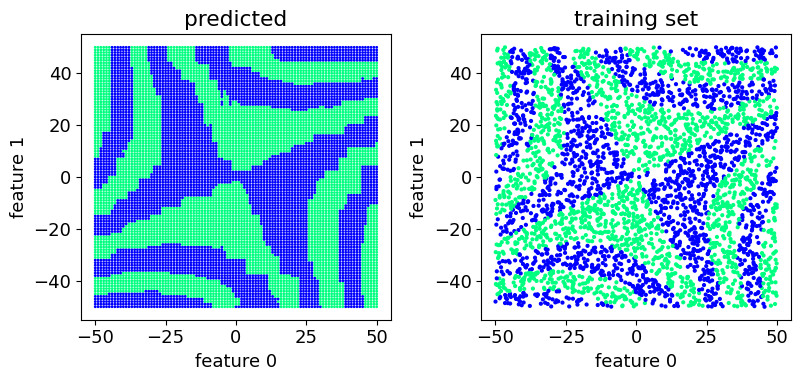

In [11]:
classify(clf=XGBClassifier(n_estimators=40,max_depth=8,reg_lambda=0.1, learning_rate=0.3,gamma=0.01,min_child_weight=1))


# Most import features

gain
[0.41903338 0.44306126 0.06554136 0.07236399]


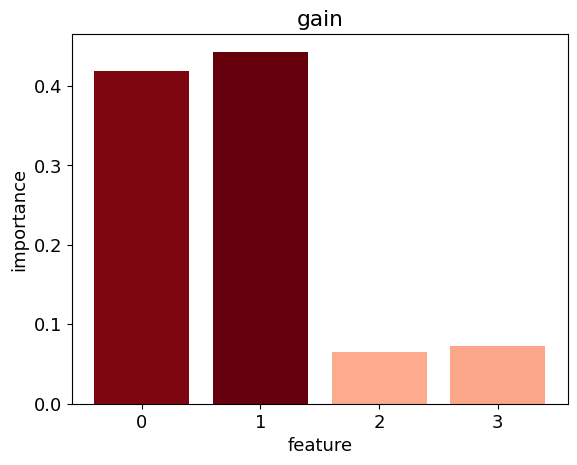

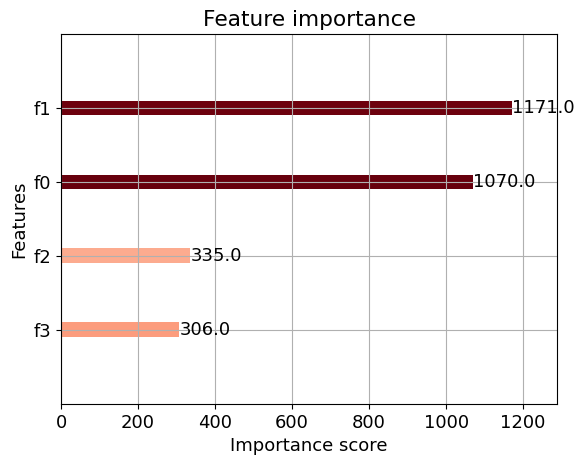

In [12]:
# https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
# feature importance

print(model.importance_type)
print(model.feature_importances_)
# plot
my_cmap = plt.get_cmap("Reds")
rescale = lambda y: 0.3 + 0.7 * (y - np.min(y)) / (np.max(y) - np.min(y))
plt.bar(range(len(model.feature_importances_)), model.feature_importances_,
        color=my_cmap(rescale(model.feature_importances_)))
plt.xlabel("feature")
plt.ylabel("importance")
plt.xticks(np.arange(L))
plt.title(model.importance_type)
plt.show()

rescale_r = lambda y: 0.3 + 0.7 * (np.max(y) - y) / (np.max(y) - np.min(y))
plot_importance(model,color=my_cmap(rescale_r(model.feature_importances_)))
plt.show()

Documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html

    ‘weight’: the number of times a feature is used to split the data across all trees.

    ‘gain’: the average gain across all splits the feature is used in.

    ‘cover’: the average coverage across all splits the feature is used in.

    ‘total_gain’: the total gain across all splits the feature is used in.

    ‘total_cover’: the total coverage across all splits the feature is used in.


0 weight [1070. 1171.  335.  306.]
1 gain [3.84043288 4.06064796 0.6006853  0.66321456]
2 total_gain [4109.26318359 4755.01904297  201.22956848  202.94364929]
3 cover [73.71099854 66.86531067 77.84243011 62.61100388]
4 total_cover [78870.765625   78299.28125    26077.21289062 19158.96679688]


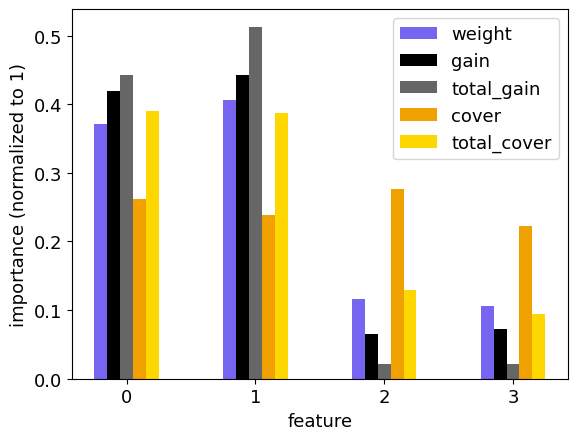

In [13]:
# if the importance type is “total_gain”, then the score is sum of loss change for each split from all trees.
list_type=["weight","gain","total_gain","cover","total_cover"]
list_col=["#7565F0","k","#666666","#F0A000","gold"]

for i,t in enumerate(list_type):
    feature_imp = model.get_booster().get_score(importance_type=t)
    keys = list(feature_imp.keys())
    values = np.array(list(feature_imp.values()))
    print(i,t,values)
    values= values/np.sum(values)
    plt.bar(np.arange(L)+(i-L/2)/10, values,color=list_col[i],width=0.1,label=t)
plt.xlabel("feature")
plt.ylabel("importance (normalized to 1)")
plt.xticks(np.arange(L))
plt.legend()
plt.show()

## Normal Gradient Boosting

errors: 19.76%   Accuracy=0.802


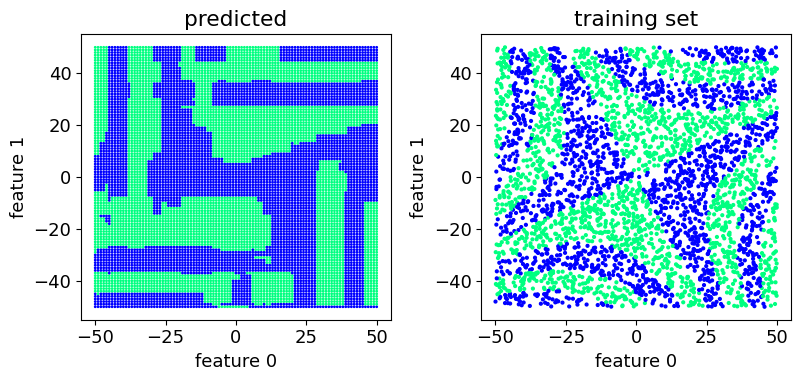

In [14]:
# GradientBoostingClassifier()
classify()

## AdaBoost

errors: 40.72%   Accuracy=0.593


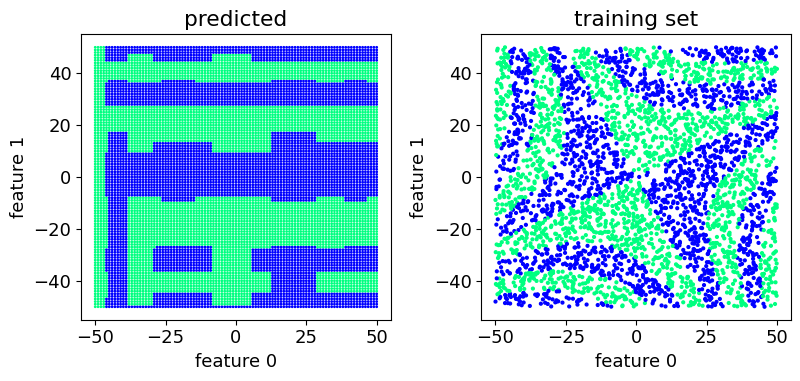

In [15]:
classify(clf=AdaBoostClassifier(learning_rate=.8,n_estimators=150))

## Part 2: Feature's reduction

In [16]:
x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]
x_train = x_train[:,:-2]
x_test= x_test[:,:-2]

(3750, 2)
errors: 6.00%   Accuracy=0.940


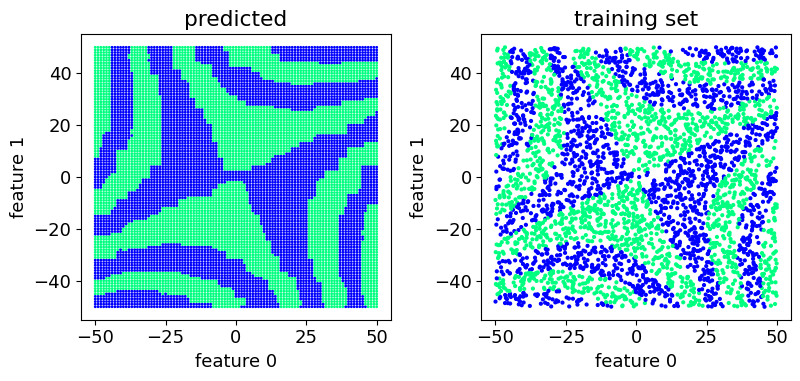

In [17]:
print(np.shape(x_train))
classify(clf=XGBClassifier(n_estimators=40,max_depth=8,reg_lambda=0.1, learning_rate=0.3,gamma=0.01,min_child_weight=1))


Dropping the two least important features f3 and f4, using the same hyperparameters previosuly found with the K-fold cross validation, the accuracy appears to improve slightly. Now we try to perform another grid search to tailor the hyperparameters acccording to the new reduced training set to check if there are significant changes and an improvement in the accuracy.


In [18]:
errors = []
accuracies = []


best_acc = 0

# after a first grid search we have rescticted the range for max_depth
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60],
    'max_depth': [6,8,10,12,14,16,18,20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.01, 0.1, 0.2],
    'lambda': [0.5,1e-1, 1e-2, 1e-3]
}

model = XGBClassifier(seed=1,
                      objective='binary:logistic',
                      importance_type="gain")
print('Training...')
start_time = time()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1) # grid search with K-fold
grid_search.fit(x_train, y_train)
cv_std = grid_search.cv_results_['std_test_score']

print('Finished!')

Training...
Fitting 5 folds for each of 7680 candidates, totalling 38400 fits
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=30; total time=   0.1s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=1, n_estimators=40; total time=   0.1s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20; total time=   0.0s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=20; total time=   0.0s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=30; total time=   0.1s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=30; total time=   0.1s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_estimators=60; total time=   0.1s
[CV] END gamma=0, lambda=0.5, learning_rate=0.01, max_depth=6, min_child_weight=3, n_esti

In [19]:
print("Best Parameters:", grid_search.best_params_)
best_index = grid_search.best_index_
cv_std= cv_std[best_index]
print("Best Accuracy (mean on validation sets):", round(grid_search.best_score_,3),"±",round(cv_std,3))

Best Parameters: {'gamma': 0.01, 'lambda': 0.1, 'learning_rate': 0.3, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 40}
Best Accuracy (mean on validation sets): 0.948 ± 0.008


We find the same best parameters for the model as with the complete training set, thus the accuracy on the test set will be the same found above:

errors: 6.00%   Accuracy=0.940


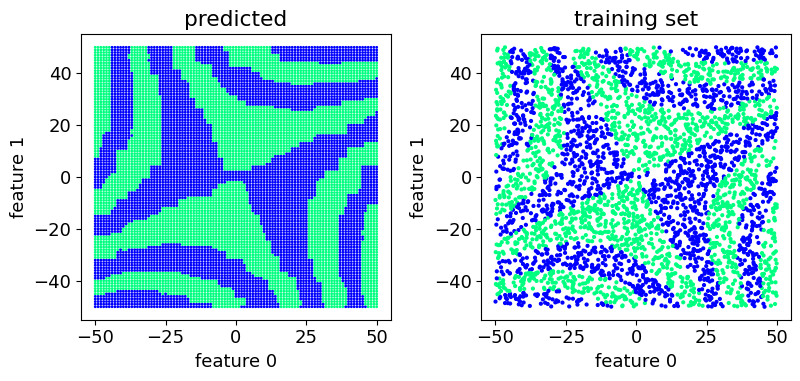

In [20]:
classify(clf=XGBClassifier(n_estimators=40,max_depth=8,reg_lambda=0.1, learning_rate=0.3,gamma=0.01,min_child_weight=1))

# Part 3: XGBoost vs NN
In this part we compare the validation accuracy of XGBoost with that of a FFNN. We want to check which one performs best with a reduced training dataset. A cross validation is going to be performed per all cases. 

First we perform a grid search on FFNN params, such that we get a satisfying accuracy.

In [84]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import warnings

x_train,y_train = x[:N_train],y[:N_train]
x_test,y_test = x[N_train:],y[N_train:]

warnings.filterwarnings('ignore')

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

NN_model = MLPClassifier(solver='sgd', max_iter = 600,
           hidden_layer_sizes=(5, 2), random_state=1)

param_grid_NN = {
    'activation': ['relu','tanh'],
    'solver': ['adam','sgd'],
    'hidden_layer_sizes': [(18,),(36,),(54,),(36, 18,),(54, 18,),(54, 36,),(54,36,18,)],#[(64,), (128,), (256,), (128, 64), (256, 128, 64)],
    'alpha': [1e-2, 1e-3, 1e-4, 1e-5],
    'max_iter': [1200]
    }
grid_search_NN = GridSearchCV(estimator=NN_model, param_grid=param_grid_NN, cv = 5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search_NN.fit(x_train_scaled, y_train)

print("Best Parameters:", grid_search_NN.best_params_)
print("Best Accuracy:", grid_search_NN.best_score_)

print('Finished!!!')


/home/luca3/Desktop/PoD/coding_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca3/Desktop/PoD/coding_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca3/Desktop/PoD/coding_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luca3/Desktop/PoD/coding_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1200) reached and the optimization hasn't converged yet.
 

Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (54, 36, 18), 'max_iter': 1200, 'solver': 'adam'}
Best Accuracy: 0.9768000000000001
Finished!!!


We do the same with XGBoost 

In [72]:
param_grid = {
    'n_estimators': [20, 30, 40, 50, 60],
    'max_depth': [6,8,10,12,14,16,18,20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.01, 0.1, 0.2],
    'lambda': [0.5,1e-1, 1e-2, 1e-3] }


tot_conf = len(lambdas) * len(n_estimators_list) * len(max_depths) * len(min_child_weights) * len(gammas)

print('Training...')
start_time = time()

grid_search_XG = GridSearchCV(estimator=model, param_grid=param_grid_XG, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search_XG.fit(x_train, y_train) # not rescaled data!!!!!!

print("Best Parameters:", grid_search_XG.best_params_)
print("Best Accuracy:", grid_search_XG.best_score_)

print('Finished!!!')

Training...
Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
Best Parameters: {'gamma': 0.001, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 60, 'reg_lambda': 0.0001}
Best Accuracy: 0.9469333333333333
Finished!!!


Once we got the best hyperparameters, we can train both the NN and the XGBoost on a selection of points from the training set

In [87]:
from sklearn.model_selection import StratifiedKFold
import warnings
import os 

warnings.filterwarnings('ignore')

fractions_of_training = np.arange(0.05,1,0.05)
k_folds = 5
kf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state = 13)

nn_accuracies = []
nn_errors = []
xg_accuracies = []
xg_errors = []
all_indexes = np.arange(0,np.shape(x_train)[0],1)
idx = 1

for fraction in fractions_of_training:
    n_points = int(np.shape(x_train)[0] * fraction)

    indexes = np.random.choice(all_indexes, size = n_points)

    #print(len(indexes))
    sel_train_x = x_train_scaled[indexes,:]
    sel_train_xxg = x_train[indexes,:]
    sel_train_y = y_train[indexes]
    KFnn_accuracies = []
    KFxg_accuracies = []
    
    # here implement k-fold
    for train_index, test_index in kf.split(sel_train_x, sel_train_y):
        KFX_train, KFX_test = sel_train_x[train_index], sel_train_x[test_index]
        KFy_train, KFy_test = sel_train_y[train_index], sel_train_y[test_index]

        KFX_trainxg, KFX_testxg = sel_train_xxg[train_index], sel_train_xxg[test_index]
        #KFy_trainxg, KFy_testxg = sel_train_y[train_index], sel_train_y[test_index]

        NN_model = MLPClassifier(
                solver=grid_search_NN.best_params_ ['solver'], 
                max_iter = grid_search_NN.best_params_ ['max_iter'],
                hidden_layer_sizes = grid_search_NN.best_params_ ['hidden_layer_sizes'],
                activation = grid_search_NN.best_params_ ['activation'],
                alpha = grid_search_NN.best_params_ ['alpha']
           )
        
        NN_model.fit(KFX_train, KFy_train)
        y_pred_nn = NN_model.predict(KFX_test)
        KFnn_accuracies.append(accuracy_score(KFy_test, y_pred_nn))
        #nn_f1s.append(f1_score(KFy_test, y_pred_nn))

        XG_model = XGBClassifier(
                      objective='binary:logistic',
                      importance_type="gain",
                      n_estimators = grid_search_XG.best_params_['n_estimators'],
                      max_depth = grid_search_XG.best_params_['max_depth'],
                      learning_rate = grid_search_XG.best_params_['learning_rate'],
                      min_child_weight = grid_search_XG.best_params_['min_child_weight'],
                      gamma = grid_search_XG.best_params_['gamma'],
                      reg_lambda = grid_search_XG.best_params_['reg_lambda']
                ) 
    
        
        XG_model.fit(KFX_trainxg, KFy_train)
        y_pred_xg = XG_model.predict(KFX_testxg)
        KFxg_accuracies.append(accuracy_score(KFy_test, y_pred_xg))
        #xg_f1s.append(f1_score(KFy_test, y_pred_xg))
    os.system('clear')
    nn_accuracies.append(np.mean(KFnn_accuracies))
    nn_errors.append(np.std(KFnn_accuracies))
    xg_accuracies.append(np.mean(KFxg_accuracies))
    xg_errors.append(np.std(KFxg_accuracies))
    print(f'done {idx} out of {len(fractions_of_training)}')
    idx += 1
        

done 1 out of 19
done 2 out of 19
done 3 out of 19
done 4 out of 19
done 5 out of 19
done 6 out of 19
done 7 out of 19
done 8 out of 19
done 9 out of 19
done 10 out of 19
done 11 out of 19
done 12 out of 19
done 13 out of 19
done 14 out of 19
done 15 out of 19
done 16 out of 19
done 17 out of 19
done 18 out of 19
done 19 out of 19


Then we plot the accuracies

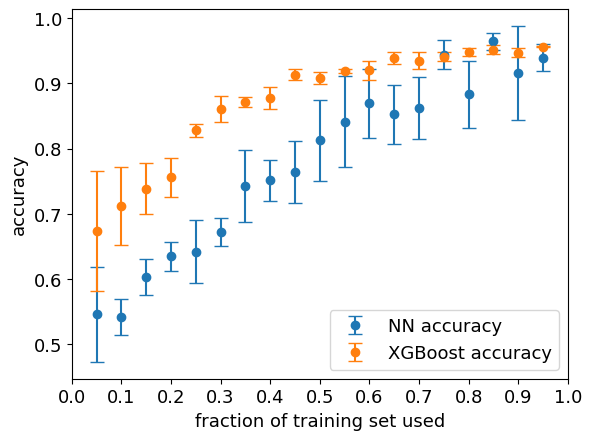

In [95]:
ps = 7
x_ticks = np.arange(0,1.1,0.1)
plt.errorbar(fractions_of_training, nn_accuracies, yerr = nn_errors, fmt = 'o', label = 'NN accuracy', capsize = 5)
plt.errorbar(fractions_of_training, xg_accuracies, yerr = xg_errors, fmt = 'o', label = 'XGBoost accuracy', capsize = 5)
plt.xlabel('fraction of training set used')
plt.ylabel('accuracy')
plt.xticks(x_ticks)
plt.legend()
#plt.grid()
plt.show()

We observe that for both models the accuracy decreases as we lower the fraction of the training set used. Accuracy of XGBoost, though, is higher than NN's for low fractions. We conclude that XGBoost is more robust to sampling the training dataset, given its tree-based nature; while the NN needs a good amount of data to perform well.